# Pierwszy i drugi milestone projektu 2. z przedmiotu WUM
### Alicja Charuza, Mateusz Gałęziewski

Poniżej przedstawiamy naszą pracę związaną z preprocessingiem danych oraz tworzeniem modeli uczenia nienadzorowanego na podstawie [zbioru danych na temat chorób serca](https://www.kaggle.com/datasets/kingabzpro/heart-disease-patients?select=heart_disease_patients.csv).

## #1 Preprocessing

In [28]:
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

Wczytywanie danych i podział na zbiór do budowy i do walidacji.

In [29]:
#loading data
def load_split():
    df = pd.read_csv('data/heart_disease_patients.csv')
    train_data, val_data = train_test_split(df, test_size=0.3, random_state=42)
    train_data.reset_index(inplace=True, drop=True)
    val_data.reset_index(inplace=True, drop=True)
    return train_data.drop(['id'], axis=1), val_data.drop(['id'], axis=1)

In [30]:
df, val_data = load_split()

In [31]:
#Let's check the shape of the dataset
df.shape, val_data.shape

((212, 11), (91, 11))

Sprawdźmy, jak wyglądają mniej więcej dane.

In [32]:
#What are the columns?
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,65,1,1,138,282,1,2,174,0,1.4,2
1,62,1,4,120,267,0,0,99,1,1.8,2
2,57,1,3,150,168,0,0,174,0,1.6,1
3,57,1,4,140,192,0,0,148,0,0.4,2
4,58,0,4,100,248,0,2,122,0,1.0,2


Dowiedzmy się trochę więcej o wartościach w poszczególnych kolumnach.

In [33]:
#Are there any missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    int64  
 1   sex       212 non-null    int64  
 2   cp        212 non-null    int64  
 3   trestbps  212 non-null    int64  
 4   chol      212 non-null    int64  
 5   fbs       212 non-null    int64  
 6   restecg   212 non-null    int64  
 7   thalach   212 non-null    int64  
 8   exang     212 non-null    int64  
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 18.3 KB


Czyli nie mamy żadnych wierszy z brakami danych.

Spróbujmy na podstawie informacji z kaggla, wyjaśnić znaczenie poszczególnych kolumn.

### Wyjaśnienie kolumn
|kolumna|opis|typ|
|:-:|:--|:-:|
|id|indeks|numeryczny|
|age|wiek|numeryczny|
|sex|płeć|kategoryczny|
|cp|typ bólu klatki piersiowej|kategoryczny|
|trestbps|ciśnienie krwi w spoczynku (w momencie przyjęcia do szpitala) w mm/Hg|numeryczny|
|chol|poziom cholesterolu w surowicy w mg/dl|numeryczny|
|fbs|poziom cukru na czczo w mg/dl > 120 (1 = true, 0 = false)|kategoryczny|
|restecg|wyniki ekg w spoczynku|kategoryczny|
|thalach|maksymalne tętno|numeryczny|
|exang|dławica wysiłkowa (1 = true, 0 = false)|kategoryczny|
|oldpeak|obniżenie odcinka ST wywołane wysiłkiem w porównaniu do spoczynku|numeryczny|
|slope|spadek odcinka ST podczas szczytowego wysiłku|kategoryczny|

### Wyjaśnienie jednostek
|jednostka|opis|
|:-:|:-:|
|mm/Hg|milimetry słupa rtęci|
|mg/dl|miligramy na decylitr|

Spójrzmy, jak wyglądają podstawowe statystyki zmiennych.

In [34]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,54.712264,0.660377,3.117925,132.386792,245.905660,0.122642,0.985849,150.452830,0.339623,1.042453,1.599057
std,9.173279,0.474702,0.988205,18.690328,47.490289,0.328802,0.999899,22.125507,0.474702,1.212060,0.626885
min,34.000000,0.000000,1.000000,94.000000,149.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000
25%,47.000000,0.000000,2.000000,120.000000,212.000000,0.000000,0.000000,137.750000,0.000000,0.000000,1.000000
50%,55.500000,1.000000,3.000000,130.000000,240.500000,0.000000,0.000000,153.000000,0.000000,0.800000,2.000000
75%,62.000000,1.000000,4.000000,140.500000,273.000000,0.000000,2.000000,167.250000,1.000000,1.600000,2.000000
max,77.000000,1.000000,4.000000,200.000000,417.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000


Zastosujemy one hot encoding dla kolumn o wartościach kategorycznych z liczbą kategorii większą niż dwa. Są to *cp*, *restecg*, *slope*.

In [35]:
#Dealing with the categorical variables
enc = OneHotEncoder()
enc_data = pd.DataFrame(enc.fit_transform(df[['cp', 'restecg', 'slope']]).toarray())
encoded_column_names = enc.get_feature_names_out(['cp', 'restecg', 'slope'])
enc_data.columns = encoded_column_names
df = (df.drop(['cp', 'restecg', 'slope'], axis=1)).join(enc_data)

In [36]:
#There are new columns 
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3
0,65,1,138,282,1,174,0,1.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,62,1,120,267,0,99,1,1.8,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,57,1,150,168,0,174,0,1.6,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,57,1,140,192,0,148,0,0.4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,58,0,100,248,0,122,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Spróbujemy teraz znormalizować/standaryzować dane. Jednak najpierw przyjrzyjmy się rozkładom poszczególnych zmiennych.

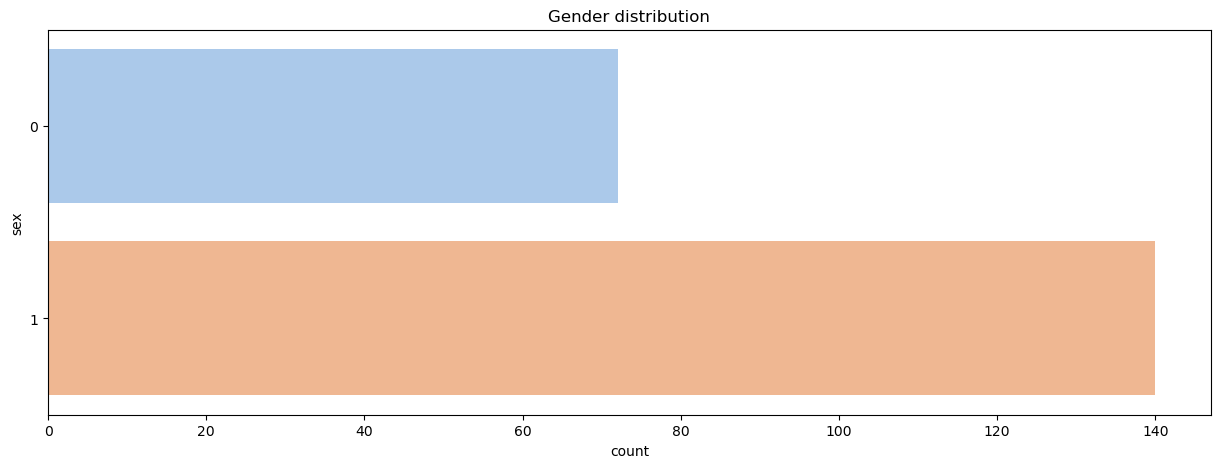

In [52]:
plt.figure(figsize=(15, 5))
sns.countplot(y='sex', data=df, palette='pastel')
plt.title('Gender distribution')
plt.show()

Jedna z płci stanowczo dominuje wśród pacjentów 


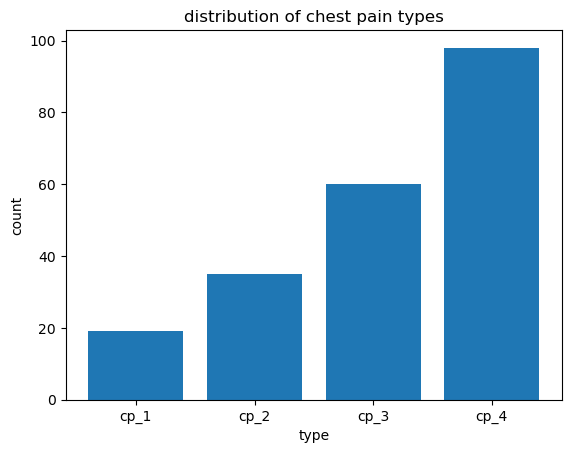

In [38]:
chest = ['cp_1','cp_2','cp_3','cp_4']
sum_values = df[chest].sum(axis=0)
plt.bar(chest, sum_values)
plt.title('distribution of chest pain types')
plt.xlabel('type')
plt.ylabel('count')
plt.show()


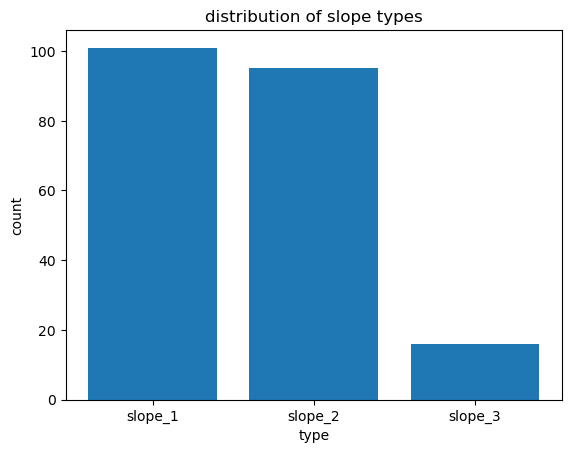

In [39]:
slope = ['slope_1','slope_2','slope_3']
sum_values = df[slope].sum(axis=0)
plt.bar(slope, sum_values)
plt.title('distribution of slope types')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

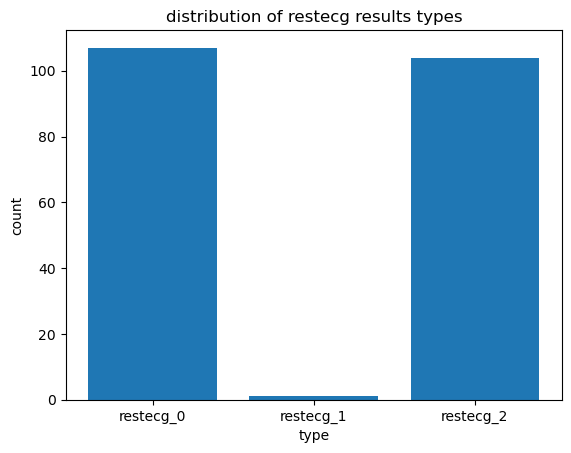

In [40]:
restecg = ['restecg_0','restecg_1','restecg_2']
sum_values = df[restecg].sum(axis=0)
plt.bar(restecg, sum_values)
plt.title('distribution of restecg results types')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

Text(0.5, 1.0, 'age')

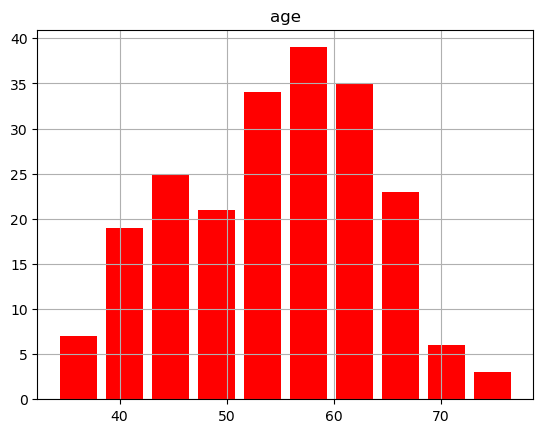

In [41]:
df['age'].hist(rwidth=0.8 , color='red')
plt.title('age')

Text(0.5, 1.0, 'trestbps')

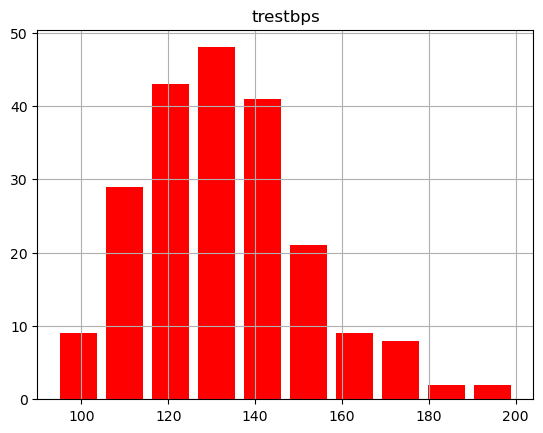

In [42]:
df['trestbps'].hist(rwidth=0.8, color='red')
plt.title('trestbps')

Text(0.5, 1.0, 'chol')

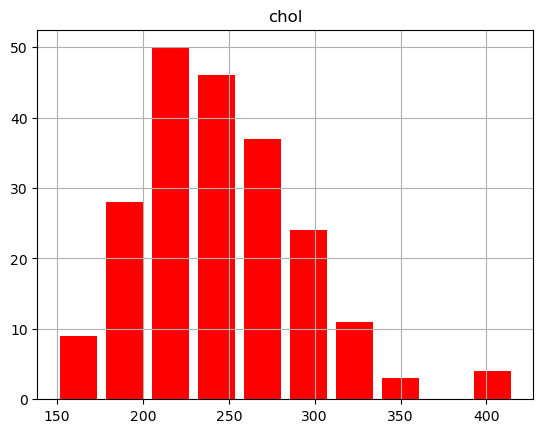

In [43]:
df['chol'].hist(rwidth=0.8 , color='red')
plt.title('chol')

Text(0.5, 1.0, 'thalach')

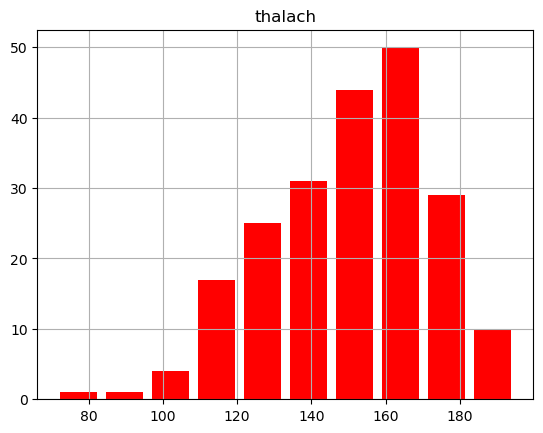

In [44]:
df['thalach'].hist(rwidth=0.8, color='red')
plt.title('thalach')

Text(0.5, 1.0, 'oldpeak')

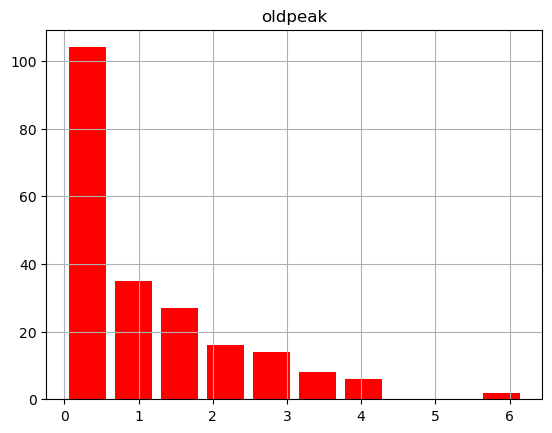

In [45]:
df['oldpeak'].hist(rwidth=0.8, color='red')
plt.title('oldpeak')

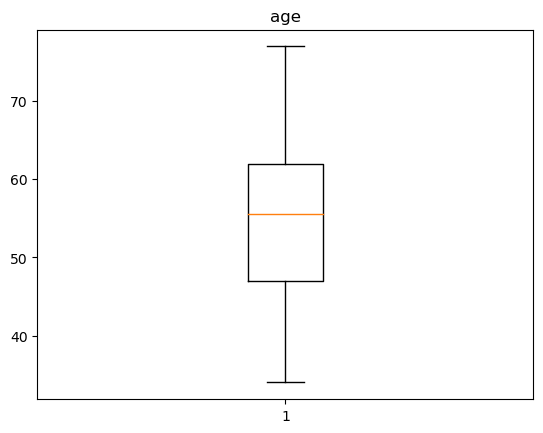

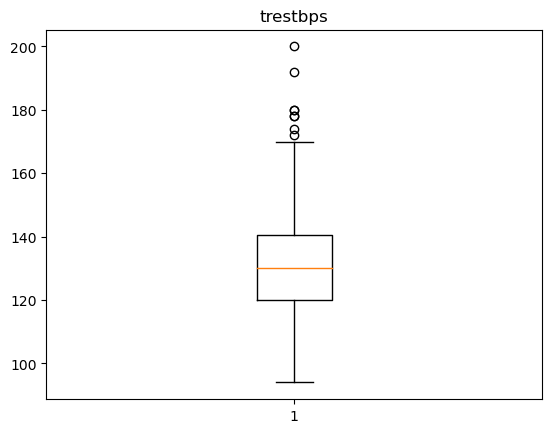

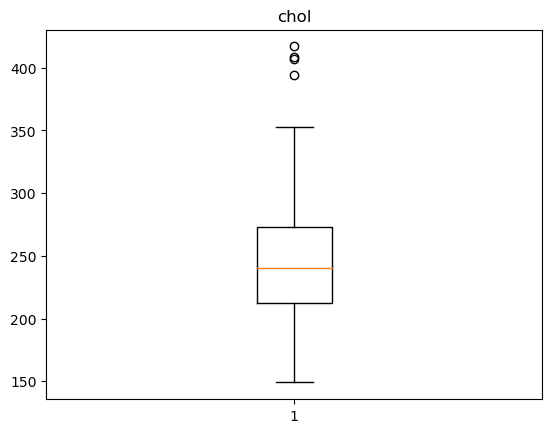

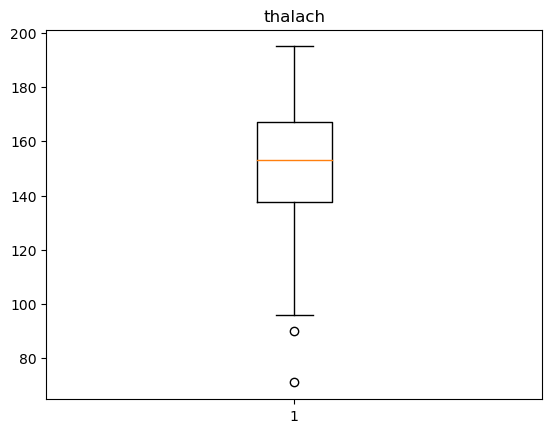

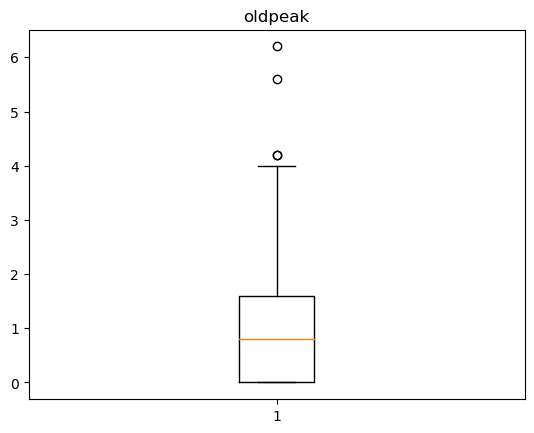

In [46]:
columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for column in columns:
    plt.boxplot(df[column])
    plt.title(column)
    plt.show()

Nasze dane mają bardzo różne rozkłady. Natomiast kierując się intuicją w zakresie interpretacji danych medycznych, nic nie robimy z wartościami odstającymi, ponieważ są w tym przypadku nośnikiem informacji nt. zdrowia pacjentów. 

### Przeprowadzamy standaryzację oraz normalizację, potem zobaczymy jak obie wersje naszych danych zachowują się w modelach nienadzorowanych.

In [47]:
# Let's scale the data
standarize = StandardScaler()
X_s = standarize.fit_transform(df)
X_standard = pd.DataFrame(X_s, columns=df.columns)
X_standard.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3
0,1.124144,0.717137,0.301038,0.761835,2.674667,1.066773,-0.717137,0.295689,3.187145,-0.44468,-0.628281,-0.927173,-1.009479,-0.068843,1.019049,-0.953892,1.109765,-0.285714
1,0.796333,0.717137,-0.664307,0.445233,-0.373878,-2.331003,1.394433,0.626487,-0.313760,-0.44468,-0.628281,1.078548,0.990610,-0.068843,-0.981307,-0.953892,1.109765,-0.285714
2,0.249982,0.717137,0.944601,-1.644337,-0.373878,1.066773,-0.717137,0.461088,-0.313760,-0.44468,1.591645,-0.927173,0.990610,-0.068843,-0.981307,1.048337,-0.901091,-0.285714
3,0.249982,0.717137,0.408298,-1.137775,-0.373878,-0.111122,-0.717137,-0.531305,-0.313760,-0.44468,-0.628281,1.078548,0.990610,-0.068843,-0.981307,-0.953892,1.109765,-0.285714
4,0.359252,-1.394433,-1.736912,0.044205,-0.373878,-1.289018,-0.717137,-0.035108,-0.313760,-0.44468,-0.628281,1.078548,-1.009479,-0.068843,1.019049,-0.953892,1.109765,-0.285714


### Redukcja wymiarowości dla danych ustandaryzowanych

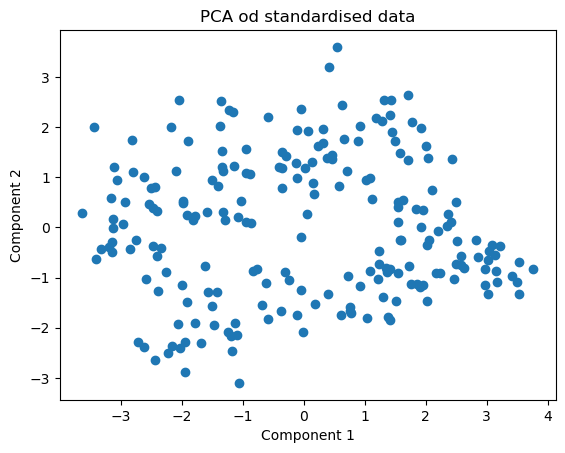

In [48]:
pca = PCA(n_components=2)
standard_pca = pca.fit_transform(X_standard)
standard_pca_df = pd.DataFrame(standard_pca, columns=['pca1', 'pca2'])
#Let's create a scatterplot
plt.scatter(standard_pca_df['pca1'], standard_pca_df['pca2'])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA od standardised data')
plt.show()

In [49]:
normalize = MinMaxScaler()
X_n = normalize.fit_transform(df)
X_normal = pd.DataFrame(X_n, columns=df.columns)
X_normal.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3
0,0.720930,1.0,0.415094,0.496269,1.0,0.830645,0.0,0.225806,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.651163,1.0,0.245283,0.440299,0.0,0.225806,1.0,0.290323,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.534884,1.0,0.528302,0.070896,0.0,0.830645,0.0,0.258065,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.534884,1.0,0.433962,0.160448,0.0,0.620968,0.0,0.064516,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.558140,0.0,0.056604,0.369403,0.0,0.411290,0.0,0.161290,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### Redukcja wymiarowości dla danych znormalizowanych 

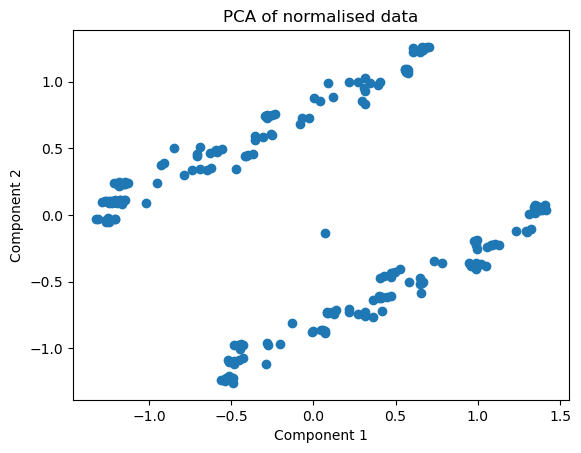

In [50]:
normal_pca = pca.fit_transform(X_normal)
normal_pca_df = pd.DataFrame(normal_pca, columns=['pca1', 'pca2'])
#Let's create a scatterplot
plt.scatter(normal_pca_df['pca1'], normal_pca_df['pca2'])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA of normalised data')
plt.show()

## #2 Modele